In [30]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.visualization import simple_norm
from astropy import units as u
import ccdproc as ccdp
from ccdproc import subtract_bias

In [31]:
DEBUG = False

if not DEBUG:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger

    warnings.simplefilter('ignore', FITSFixedWarning)
    warnings.simplefilter('ignore', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.ERROR)
else:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger
    
    warnings.simplefilter('default', FITSFixedWarning)
    warnings.simplefilter('default', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.INFO)

In [32]:
files = ccdp.ImageFileCollection(r'..\data\M63\lights')
files.summary['file', 'naxis1', 'naxis2', 'imagetyp', 'exptime', 'gain', 'offset']

file,naxis1,naxis2,imagetyp,exptime,gain,offset
str44,int64,int64,str5,float64,int64,int64
2025-08-02_23-11-23__23.30_180.00s_0001.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-14-24__23.30_180.00s_0002.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-17-24__23.50_180.00s_0003.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-20-24__23.70_180.00s_0004.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-23-24__23.80_180.00s_0005.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-26-25__23.80_180.00s_0006.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-29-25__23.70_180.00s_0007.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-32-25__23.50_180.00s_0008.fits,3096,2078,LIGHT,180.0,30,100
2025-08-02_23-35-25__23.60_180.00s_0009.fits,3096,2078,LIGHT,180.0,30,100


In [33]:
#копируем файлы из папки data_NGC6888 в папку reduced
calibrated_data = Path(r'..\data\reduced')
calibrated_data.mkdir(exist_ok=True)

lights = files.files_filtered(imagetyp='Light', include_path=True)

import shutil

for light in lights:
    shutil.copy(light, calibrated_data)

In [34]:
calibrated_path = Path(r'..\data\reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_lights = reduced_images.files_filtered(imagetyp='Light', include_path=True)

raw_ccds = list(reduced_images.ccds(imagetyp='Light',
                                     ccd_kwargs={'unit': 'adu'},
                                     return_fname=True))

light_file = calibrated_lights[0]
light_ccd = CCDData.read(light_file, unit='adu') 

light_data = light_ccd.data

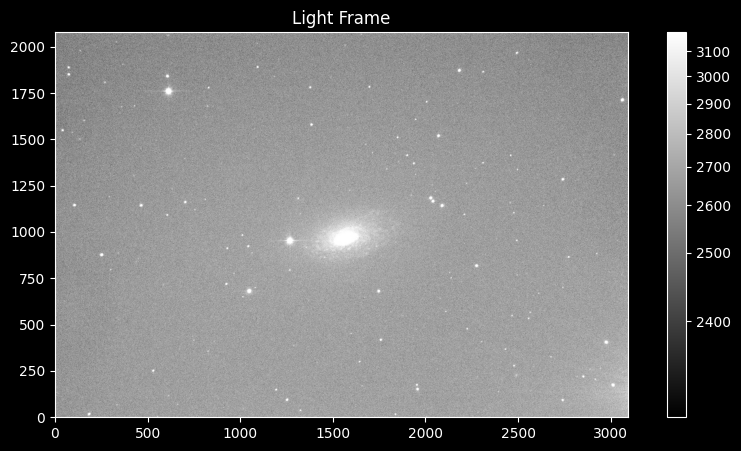

In [35]:
norm = simple_norm(light_data, stretch='sqrt', percent=99)
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.imshow(light_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar()
plt.title('Light Frame')
plt.show()

Mean: 2679.1365411733104
STD: 412.4076310241924
MAD STD: 130.468995228493


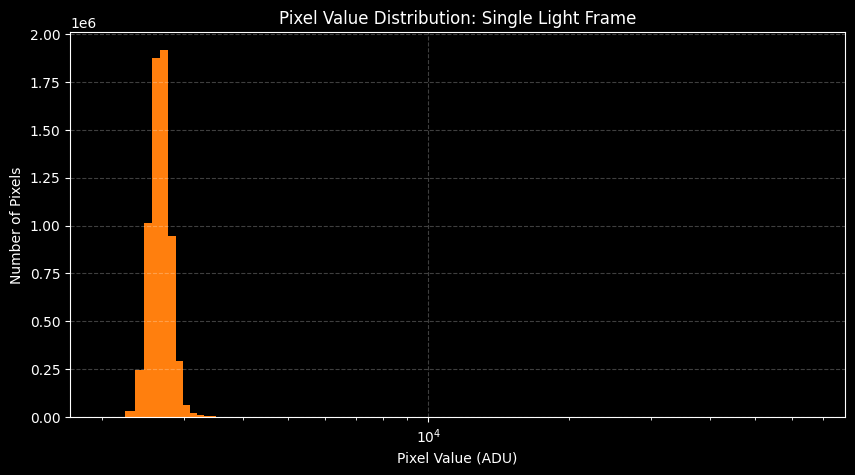

In [36]:
light_hist = light_data.flatten()

print(f'Mean: {np.mean(light_data)}')
print(f'STD: {np.std(light_data)}')
print(f'MAD STD: {mad_std(light_data)}')

plt.figure(figsize=(10, 5))
plt.hist(light_hist, bins=600, color='tab:orange')
plt.title('Pixel Value Distribution: Single Light Frame')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.semilogx()
plt.show()

# 1. Subtract Dark w/o Bias and Bias

In [37]:
combined_bias = [ccd for ccd in reduced_images.ccds(imagetyp='Bias', combined=True)][0]

combined_dark_wo_bias = CCDData.read(calibrated_data / 'combined_dark_avg_wo_bias.fit')

In [38]:
all_reds = []
light_ccds = []
for light, file_name in raw_ccds:
    print(f"Mean before anything: {np.mean(light.data)}")
    
    light_ccds.append(light)

    reduced = light
    
    reduced = ccdp.subtract_bias(reduced, combined_bias)

    reduced = ccdp.subtract_dark(reduced, combined_dark_wo_bias, 
                                 exposure_time='exptime', exposure_unit=u.second)
    
    all_reds.append(reduced)
    reduced.write(calibrated_data / file_name, overwrite=True)

Mean before anything: 2679.1365411733104
Mean before anything: 2572.203596556021
Mean before anything: 2489.219286334256
Mean before anything: 2427.482421355259
Mean before anything: 2373.8262783734112
Mean before anything: 2348.6902078623602
Mean before anything: 2333.5938377440043
Mean before anything: 2309.0409382903954
Mean before anything: 2283.7658638673142
Mean before anything: 2269.213671961462
Mean before anything: 2214.5754701026876
Mean before anything: 2227.405470251907
Mean before anything: 2170.9890696928323
Mean before anything: 2148.960759078124
Mean before anything: 2132.5261189575544
Mean before anything: 2127.6725819648686
Mean before anything: 2135.3693330896085
Mean before anything: 2165.0834837960374
Mean before anything: 2185.546541471749


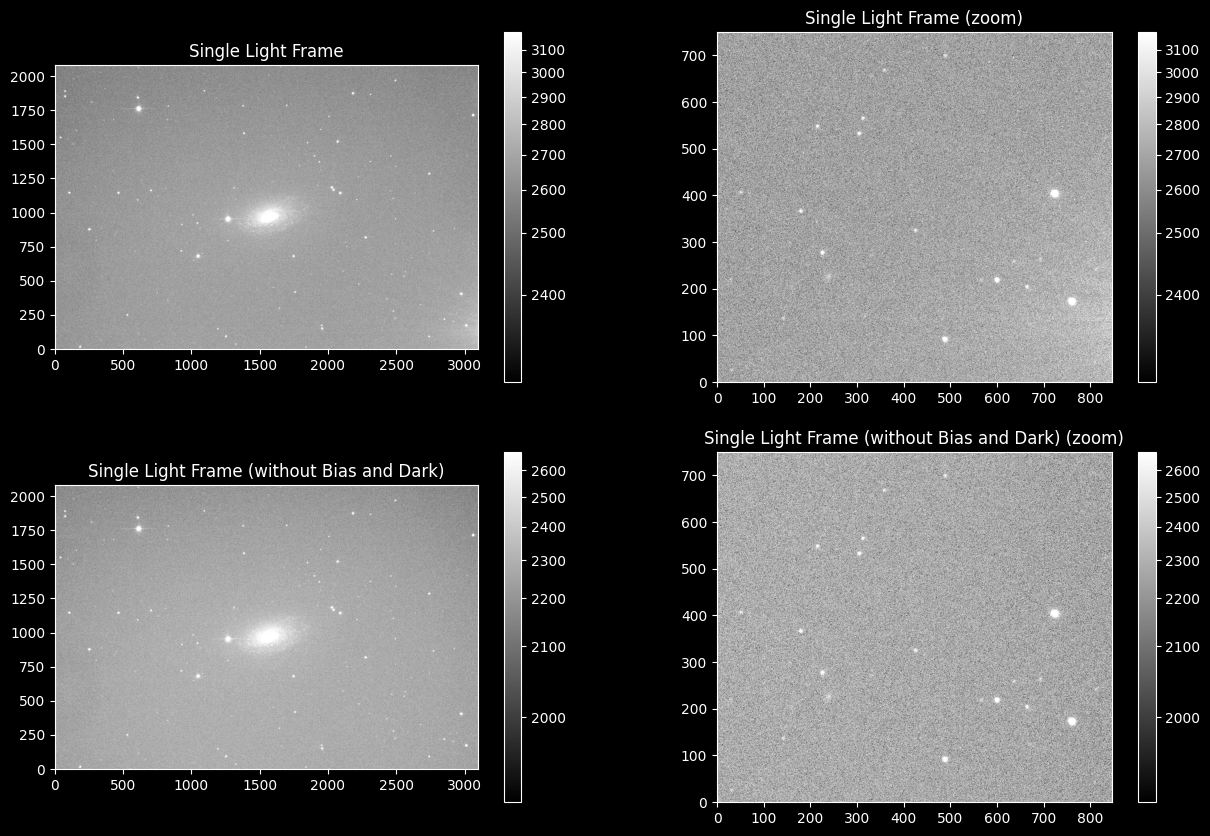

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(light_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Light Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(light_data[0:750, 2250:3096], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Light Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(all_reds[0].data, stretch='sqrt', percent=99)
im3 = ax3.imshow(all_reds[0].data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Single Light Frame (without Bias and Dark)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(all_reds[0].data, stretch='sqrt', percent=99)
im4 = ax4.imshow(all_reds[0].data[0:750, 2250:3096], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Single Light Frame (without Bias and Dark) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()

# 2. Subtract just Dark with Bias

In [42]:
combined_dark = CCDData.read(calibrated_data / 'combined_dark_avg.fit')

In [43]:
all_reds_d = []
light_ccds = []
for light, file_name in raw_ccds:
    print(f"Mean before anything: {np.mean(light.data)}")
    
    light_ccds.append(light)

    reduced = light

    reduced = ccdp.subtract_dark(reduced, combined_dark, 
                                 exposure_time='exptime', exposure_unit=u.second)
    
    all_reds_d.append(reduced)

Mean before anything: 2679.1365411733104
Mean before anything: 2572.203596556021
Mean before anything: 2489.219286334256
Mean before anything: 2427.482421355259
Mean before anything: 2373.8262783734112
Mean before anything: 2348.6902078623602
Mean before anything: 2333.5938377440043
Mean before anything: 2309.0409382903954
Mean before anything: 2283.7658638673142
Mean before anything: 2269.213671961462
Mean before anything: 2214.5754701026876
Mean before anything: 2227.405470251907
Mean before anything: 2170.9890696928323
Mean before anything: 2148.960759078124
Mean before anything: 2132.5261189575544
Mean before anything: 2127.6725819648686
Mean before anything: 2135.3693330896085
Mean before anything: 2165.0834837960374
Mean before anything: 2185.546541471749


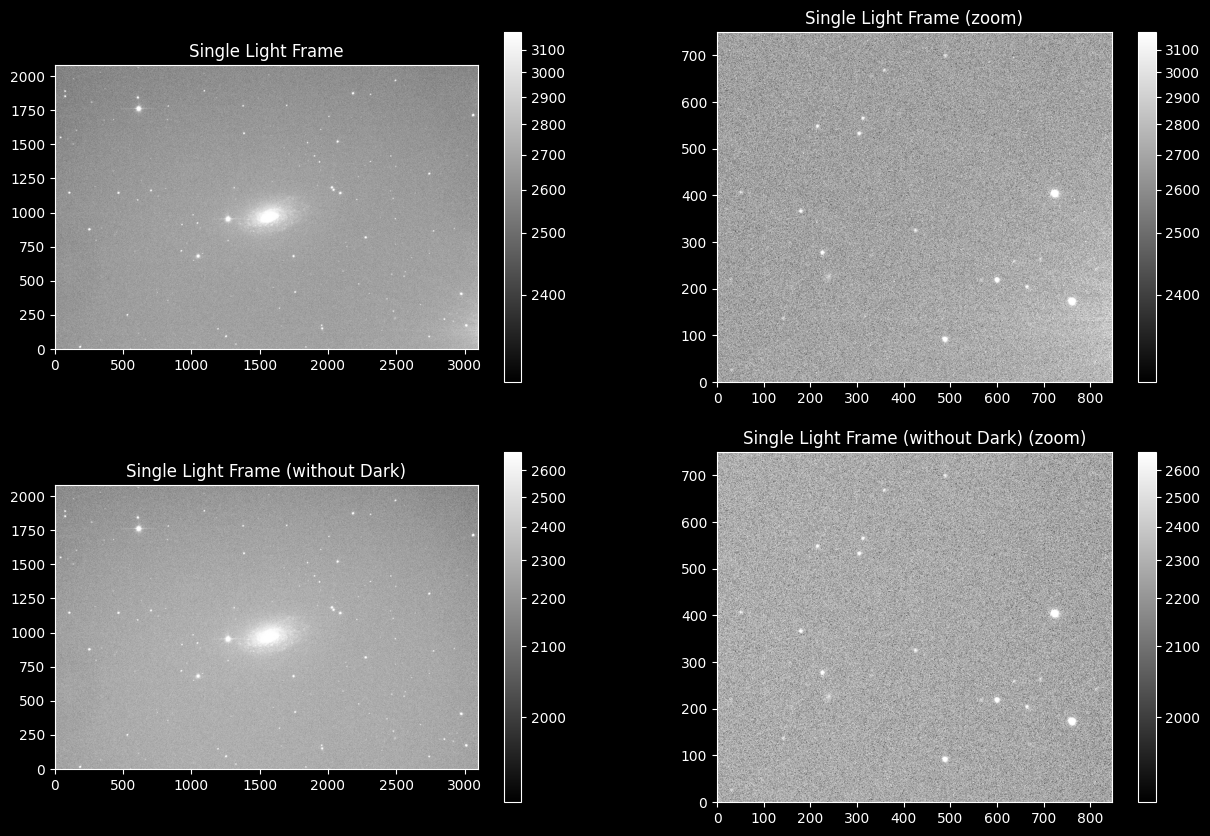

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(light_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Light Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(light_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(light_data[0:750, 2250:3096], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Light Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(all_reds_d[0].data, stretch='sqrt', percent=99)
im3 = ax3.imshow(all_reds_d[0].data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Single Light Frame (without Dark)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(all_reds_d[0].data, stretch='sqrt', percent=99)
im4 = ax4.imshow(all_reds_d[0].data[0:750, 2250:3096], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Single Light Frame (without Dark) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()

Single Light Frame
Mean: 2679.1365411733104
STD: 412.4076310241924
MAD STD: 130.468995228493 

Single Light Frame (w/o Bias and Dark)
Mean: 2284.826149652104
STD: 405.34677858020024
MAD STD: 126.91074990407873 

Single Light Frame (w/o Dark)
Mean: 2284.826149652104
STD: 405.34677858020024
MAD STD: 126.9107499040794


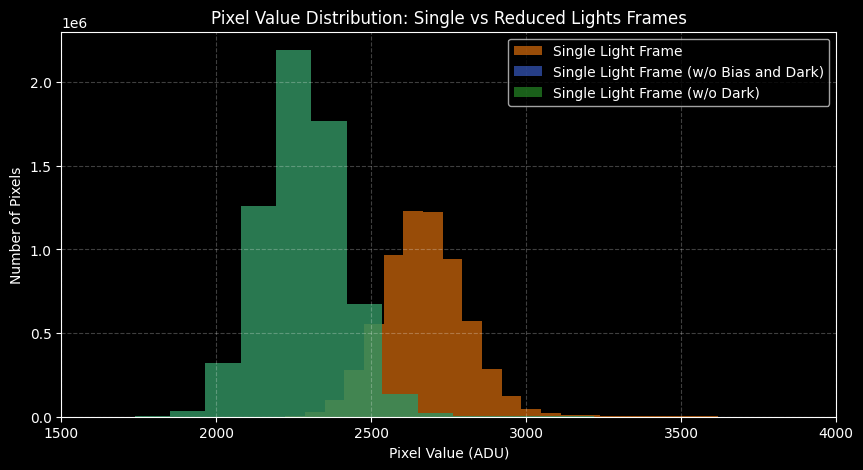

In [50]:
print('Single Light Frame')
print(f'Mean: {np.mean(light_data)}')
print(f'STD: {np.std(light_data)}')
print(f'MAD STD: {mad_std(light_data)} \n')

print('Single Light Frame (w/o Bias and Dark)')
print(f'Mean: {np.mean(all_reds[0].data)}')
print(f'STD: {np.std(all_reds[0].data)}')
print(f'MAD STD: {mad_std(all_reds[0].data)} \n')

print('Single Light Frame (w/o Dark)')
print(f'Mean: {np.mean(all_reds_d[0].data)}')
print(f'STD: {np.std(all_reds_d[0].data)}')
print(f'MAD STD: {mad_std(all_reds_d[0].data)}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(light_data.flatten(), bins=1000, color='tab:orange', alpha=0.6, label='Single Light Frame')
plt.hist(all_reds[0].data.flatten(), bins=1000, color='royalblue', alpha=0.6, label='Single Light Frame (w/o Bias and Dark)')
plt.hist(all_reds_d[0].data.flatten(), bins=1000, color='tab:green', alpha=0.6, label='Single Light Frame (w/o Dark)')
plt.title('Pixel Value Distribution: Single vs Reduced Lights Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.xlim(1500, 4000)
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.show()